In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy import stats
from functools import partial
from collections import Counter
from pathlib import Path

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)

In [121]:
cwd = Path.cwd()
data_path = cwd / 'data.xlsx'

In [122]:
df = pd.read_excel(
    data_path, sheet_name=0, engine='openpyxl', header=[0]
) #, header=[0,1]

In [123]:
df.columns

Index(['Unique ID', 'Email', 'Date Taken (America/New_York)', 'Time Taken (America/New_York)', 'Browser', 'OS', 'City', 'Country', 'Referrer', 'Time Spent', 'Q1 - Which Title Best Fits your Current Role?', 'Q2 - Did you switch careers into Data?', 'Q3 - Current Yearly Salary (in USD)', 'Q4 - What Industry do you work in?', 'Q5 - Favorite Programming Language', 'Q6 - How Happy are you in your Current Position with the following? (Salary)', 'Q6 - How Happy are you in your Current Position with the following? (Work/Life Balance)', 'Q6 - How Happy are you in your Current Position with the following? (Coworkers)', 'Q6 - How Happy are you in your Current Position with the following? (Management)', 'Q6 - How Happy are you in your Current Position with the following? (Upward Mobility)', 'Q6 - How Happy are you in your Current Position with the following? (Learning New Things)', 'Q7 - How difficult was it for you to break into Data?',
       'Q8 - If you were to look for a new job today, what w

In [124]:
df.shape

(630, 28)

In [125]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 28 columns):
 #   Column                                                                                        Non-Null Count  Dtype  
---  ------                                                                                        --------------  -----  
 0   Unique ID                                                                                     630 non-null    object 
 1   Email                                                                                         630 non-null    object 
 2   Date Taken (America/New_York)                                                                 630 non-null    object 
 3   Time Taken (America/New_York)                                                                 630 non-null    object 
 4   Browser                                                                                       0 non-null      float64
 5   OS                           

In [126]:
df = df.dropna(axis=1, how='all')

In [127]:
for column in df.select_dtypes(include='object').columns:
    unique_types = df[column].apply(type).unique()
    print(f"Column '{column}' has unique types: {unique_types}")

Column 'Unique ID' has unique types: [<class 'str'>]
Column 'Email' has unique types: [<class 'str'>]
Column 'Date Taken (America/New_York)' has unique types: [<class 'str'>]
Column 'Time Taken (America/New_York)' has unique types: [<class 'str'>]
Column 'Time Spent' has unique types: [<class 'str'>]
Column 'Q1 - Which Title Best Fits your Current Role?' has unique types: [<class 'str'>]
Column 'Q2 - Did you switch careers into Data?' has unique types: [<class 'str'>]
Column 'Q3 - Current Yearly Salary (in USD)' has unique types: [<class 'str'>]
Column 'Q4 - What Industry do you work in?' has unique types: [<class 'str'>]
Column 'Q5 - Favorite Programming Language' has unique types: [<class 'str'>]
Column 'Q7 - How difficult was it for you to break into Data?' has unique types: [<class 'str'>]
Column 'Q8 - If you were to look for a new job today, what would be the most important thing to you?' has unique types: [<class 'str'>]
Column 'Q9 - Male/Female?' has unique types: [<class 'str'>

In [128]:
df.dtypes

Unique ID                                                                                        object
Email                                                                                            object
Date Taken (America/New_York)                                                                    object
Time Taken (America/New_York)                                                                    object
Time Spent                                                                                       object
Q1 - Which Title Best Fits your Current Role?                                                    object
Q2 - Did you switch careers into Data?                                                           object
Q3 - Current Yearly Salary (in USD)                                                              object
Q4 - What Industry do you work in?                                                               object
Q5 - Favorite Programming Language                              

# Renaming Columns

In [129]:
df = df.rename(columns={
    'Unique ID':'ID',
    'Time Spent':'Duration_sec',
    'Date Taken (America/New_York)':'Date_NY',
    'Time Taken (America/New_York)':'Time_NY',
    'Q1 - Which Title Best Fits your Current Role?':'CurrentJob',
    'Q2 - Did you switch careers into Data?':'CarrerSwitch',
    'Q3 - Current Yearly Salary (in USD)':'SaleryRange_USDperYear',
    'Q4 - What Industry do you work in?':'WorkField',
    'Q5 - Favorite Programming Language':'FavLanguage',
    'Q6 - How Happy are you in your Current Position with the following? (Salary)':'SalerySat',
    'Q6 - How Happy are you in your Current Position with the following? (Work/Life Balance)':'WLBalanceSat',
    'Q6 - How Happy are you in your Current Position with the following? (Coworkers)':'CoworkerSat',
    'Q6 - How Happy are you in your Current Position with the following? (Management)':'ManagementSat',
    'Q6 - How Happy are you in your Current Position with the following? (Upward Mobility)':'UpwardMobSat',
    'Q6 - How Happy are you in your Current Position with the following? (Learning New Things)':'DevelopmentSat',
    'Q7 - How difficult was it for you to break into Data?':'EntryDifficulty',
    'Q8 - If you were to look for a new job today, what would be the most important thing to you?':'JobImportance',
    'Q9 - Male/Female?':'Sex', 
    'Q10 - Current Age':'Age',
    'Q11 - Which Country do you live in?':'HomeContry',
    'Q12 - Highest Level of Education':'Education', 
    'Q13 - Ethnicity':'Ethnicity'
})

# Transforming the Data

In [130]:
# df['Date_NY'] = pd.to_datetime(df['Date_NY'] + ' ' + df['Time_NY'])
# df.drop(columns=['Date_NY','Time_NY', 'Email'], inplace=True)

df['Date_NY'] = pd.to_datetime(df['Date_NY'], format='%m/%d/%Y')
df['WeekDay'] = df['Date_NY'].dt.day_name()
df['Time_NY'] = pd.to_datetime(df['Time_NY'], format='%H:%M').dt.time

df['Duration_sec'] = pd.to_timedelta(df['Duration_sec']) / pd.Timedelta(seconds=1)

In [131]:
df['CarrerSwitch'] = np.where(df['CarrerSwitch'] == 'Yes', True, False)

In [132]:
def extract_and_calculate_mean(entry):
    # Replace 'k' with '000'
    entry = entry.replace('k', '000')

    # Extract all numbers using regular expression
    numbers = [int(match) for match in re.findall(r'\d+', entry)]

    # Calculate the mean
    mean_value = np.mean(numbers)

    return mean_value

df['SaleryMean_USDperYear'] = df['SaleryRange_USDperYear'].apply(extract_and_calculate_mean)

In [133]:
def remove_other_category(input_series:pd.Series, theshold:int=4) -> pd.Series:
    # Create a copy of the original series to avoid modifying the input directly
    new_series = input_series.copy()

    # Identify rows containing 'other (Please Specify):'
    contains_other = new_series.str.contains('Other \\(Please Specify\\):', case=False)

    # Count occurrences of 'other (Please Specify):'
    other_counts = new_series[contains_other].value_counts()

    # Filter values with more than one occurrence
    multiple_occurrences = other_counts[other_counts > theshold].index

    # Update values in rows with multiple occurrences
    new_series.loc[contains_other & new_series.isin(multiple_occurrences)] = new_series.str.split(':').str[1].str.strip()

    return new_series

def extract_words_count(input_series:pd.Series) -> pd.Series:
    # Create a copy of the original series to avoid modifying the input directly
    new_series = input_series.copy()

    # Identify rows containing 'other (Please Specify):'
    contains_other = new_series.str.contains(r'Other \(Please Specify\):', case=False)

    # Extract words following 'other (Please Specify):' and count occurrences
    words_count = Counter()

    for value in new_series[contains_other]:
        words = re.findall(r'Other \(Please Specify\):([^:]+)', value)[0].lower().split()
        words_count.update(words)

    return pd.Series(words_count)

df['CurrentJob'] = remove_other_category(df['CurrentJob'])
df['WorkField'] = remove_other_category(df['WorkField'])

In [134]:
semi_job_categories = {
    'analyst':'Analytics',
    'analytics':'Analytics',
    'scientist':'Science',
    'student':'Science',
    'researchers':'Science',
    'research':'Science',
    'finance':'Business',
    'business':'Business',
    'manager':'Business',
    'sales':'Business',
    'specialist':'IT',
    'engineer':'IT',
    'software':'IT',
    'developer':'IT',  
}

# TODO: Ist eher Scheiße geworden die Logik. Das kann man alles Cleaner machen, aber ich will jetzt erstmal ergebnisse und gucke dann!
def replace_cat(entry:str, semi_cats:dict[str:str]={}, categorize_other=True)->str:
    """Checks if entry contains other cat and then if is key of semi_cats

    Args:
        entry (str): _description_
        semi_cats (dict[str:str]): _description_

    Raises:
        Exception: _description_

    Returns:
        str: _description_
    """
    try: 
        words = re.findall(r'Other \(Please Specify\):([^:]+)', entry)[0].lower().split()
    except IndexError:
        if 'other' in entry.lower():
            return 'Other' #Other (Please Specify) only
        else:
            return entry #Allready is a Category different from other
    
    if any(word in words for word in semi_cats):
        for word in words:
            try:
                return semi_cats[word] #Is a semi Category
            except KeyError:
                pass
        raise Exception("if statement triggered but nothing was passed")
    else:
        if categorize_other:
            return 'Other' #Other category
        else:
            return ' '.join(words).title()


df['CurrentJob'] = df['CurrentJob'].apply(partial(replace_cat,semi_cats=semi_job_categories))
df['WorkField'] = df['WorkField'].apply(partial(replace_cat,semi_cats={}))
df['JobImportance'] = df['JobImportance'].apply(partial(replace_cat,semi_cats={}))
df['FavLanguage'] = df['FavLanguage'].apply(partial(replace_cat,semi_cats={}))

# eigentlich muss ich nach anderen Ländern scannen, da da auch falsche einträge sind!
df['HomeContry'] = df['HomeContry'].apply(partial(replace_cat,semi_cats={}), categorize_other=False)
df['Ethnicity'] = df['Ethnicity'].apply(partial(replace_cat,semi_cats={}))

In [135]:
df['Education'] = df['Education'].fillna('Not Specified')

In [136]:
df = df.dropna(axis=0)
df = df.drop(columns=['Email'])

In [137]:
df.describe(include='all').T
# look for possible outliers (e.g. max Duration) or errors or scewness (eg. Age)

count unique                         top freq                           mean                  min                  25%                  50%                  75%                  max           std
ID                        612    612    62a33b3db4da29969c62df3d    1                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
Date_NY                   612    NaN                         NaN  NaN  2022-06-11 10:21:10.588235264  2022-06-10 00:00:00  2022-06-10 00:00:00  2022-06-10 00:00:00  2022-06-12 00:00:00  2022-06-26 00:00:00           NaN
Time_NY                   612    440                    08:52:00    6                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
Duration_sec            612.0    NaN                         NaN  NaN                     199.980392                 28.0                 85.0                111.0                152.0              38083.0   1545.879551
CurrentJob                612     12                Data Analyst  370                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
CarrerSwitch              612      2                        True  361                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
SaleryRange_USDperYear    612      8                       0-40k  263                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
WorkField                 612     14                       Other  158                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
FavLanguage               612      6                      Python  409                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
SalerySat               612.0    NaN                         NaN  NaN                        4.29902                  0.0                  2.0                  4.0                  7.0                 10.0      2.772403
WLBalanceSat            612.0    NaN                         NaN  NaN                       5.754902                  0.0                  4.0                  6.0                  8.0                 10.0      2.769732
CoworkerSat             612.0    NaN                         NaN  NaN                       5.859477                  0.0                  4.0                  6.0                  8.0                 10.0      2.710202
ManagementSat           612.0    NaN                         NaN  NaN                       5.326797                  0.0                  4.0                  5.0                  7.0                 10.0      2.741641
UpwardMobSat            612.0    NaN                         NaN  NaN                       4.743464                  0.0                  3.0                  5.0                  7.0                 10.0      2.819944
DevelopmentSat          612.0    NaN                         NaN  NaN                       5.594771                  0.0                  3.0                  6.0                  8.0                 10.0      3.012115
EntryDifficulty           612      5  Neither easy nor difficult  264                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
JobImportance             612      5               Better Salary  293                            NaN                  NaN                  NaN                  NaN                  NaN                  NaN           NaN
Sex                       612      2                        Male

In [138]:
df.info(verbose=True)
# TODO: Sanity Check ob noch was falsch ist

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 629
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      612 non-null    object        
 1   Date_NY                 612 non-null    datetime64[ns]
 2   Time_NY                 612 non-null    object        
 3   Duration_sec            612 non-null    float64       
 4   CurrentJob              612 non-null    object        
 5   CarrerSwitch            612 non-null    bool          
 6   SaleryRange_USDperYear  612 non-null    object        
 7   WorkField               612 non-null    object        
 8   FavLanguage             612 non-null    object        
 9   SalerySat               612 non-null    float64       
 10  WLBalanceSat            612 non-null    float64       
 11  CoworkerSat             612 non-null    float64       
 12  ManagementSat           612 non-null    float64       


In [139]:
cat_cols=[item for item in df.select_dtypes(include=['object']).columns.tolist() if item not in ['Time_NY', 'ID']]
num_cols = [item for item in df.select_dtypes(include=np.number).columns.tolist() if item not in ['Time_NY', 'Date_NY']]

In [140]:
df['Date_NY'].value_counts()

Date_NY
2022-06-10    336
2022-06-11    102
2022-06-12     50
2022-06-13     42
2022-06-15     25
2022-06-14     18
2022-06-16     12
2022-06-19      8
2022-06-18      4
2022-06-21      4
2022-06-17      3
2022-06-22      2
2022-06-23      2
2022-06-25      2
2022-06-24      1
2022-06-26      1
Name: count, dtype: int64

# Remove Outliers

In [141]:
def remove_outliers(df:pd.DataFrame, columns:list, z_thresholds:list) -> pd.DataFrame:
    # Copy the original DataFrame to avoid modifying the original data
    df_no_outliers = df.copy()

    for column, z_threshold in zip(columns, z_thresholds):
        if column not in df.columns:
            print(f"Column '{column}' not found in the DataFrame. Skipping...")
            continue

        series = df[column]

        if pd.api.types.is_numeric_dtype(series):
            # Calculate Z-scores for each data point in the column
            z_scores = stats.zscore(series)

            # Identify and remove rows with Z-scores beyond the threshold
            outliers = (np.abs(z_scores) > z_threshold)
            outlier_rows = df_no_outliers[outliers].index

            # Print information about removed rows and their Z-scores
            if not outlier_rows.empty:
                print(f"Removed outliers in column '{column}':")
                for index in outlier_rows:
                    print(f"   Row {index}, Z-score: {z_scores[index]}")
                df_no_outliers = df_no_outliers.drop(index=outlier_rows)
        else:
            print(f"Column '{column}' contains non-numerical data. Skipping...")

    return df_no_outliers

df = remove_outliers(df, ['Duration_sec', 'Age'], [2, 5])


Removed outliers in column 'Duration_sec':
   Row 328, Z-score: 2.5799418426449403
   Row 429, Z-score: 24.5258485603568
Removed outliers in column 'Age':
   Row 360, Z-score: 8.59926624419828
   Row 624, Z-score: 5.0012771703701695


C:\Users\veusc\AppData\Local\Temp\ipykernel_11764\4272266332.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outlier_rows = df_no_outliers[outliers].index


# Save to CSV

In [142]:
df.to_csv(cwd / 'clean_data.csv', index=False, date_format="%d-%m-%Y")

# Visualization

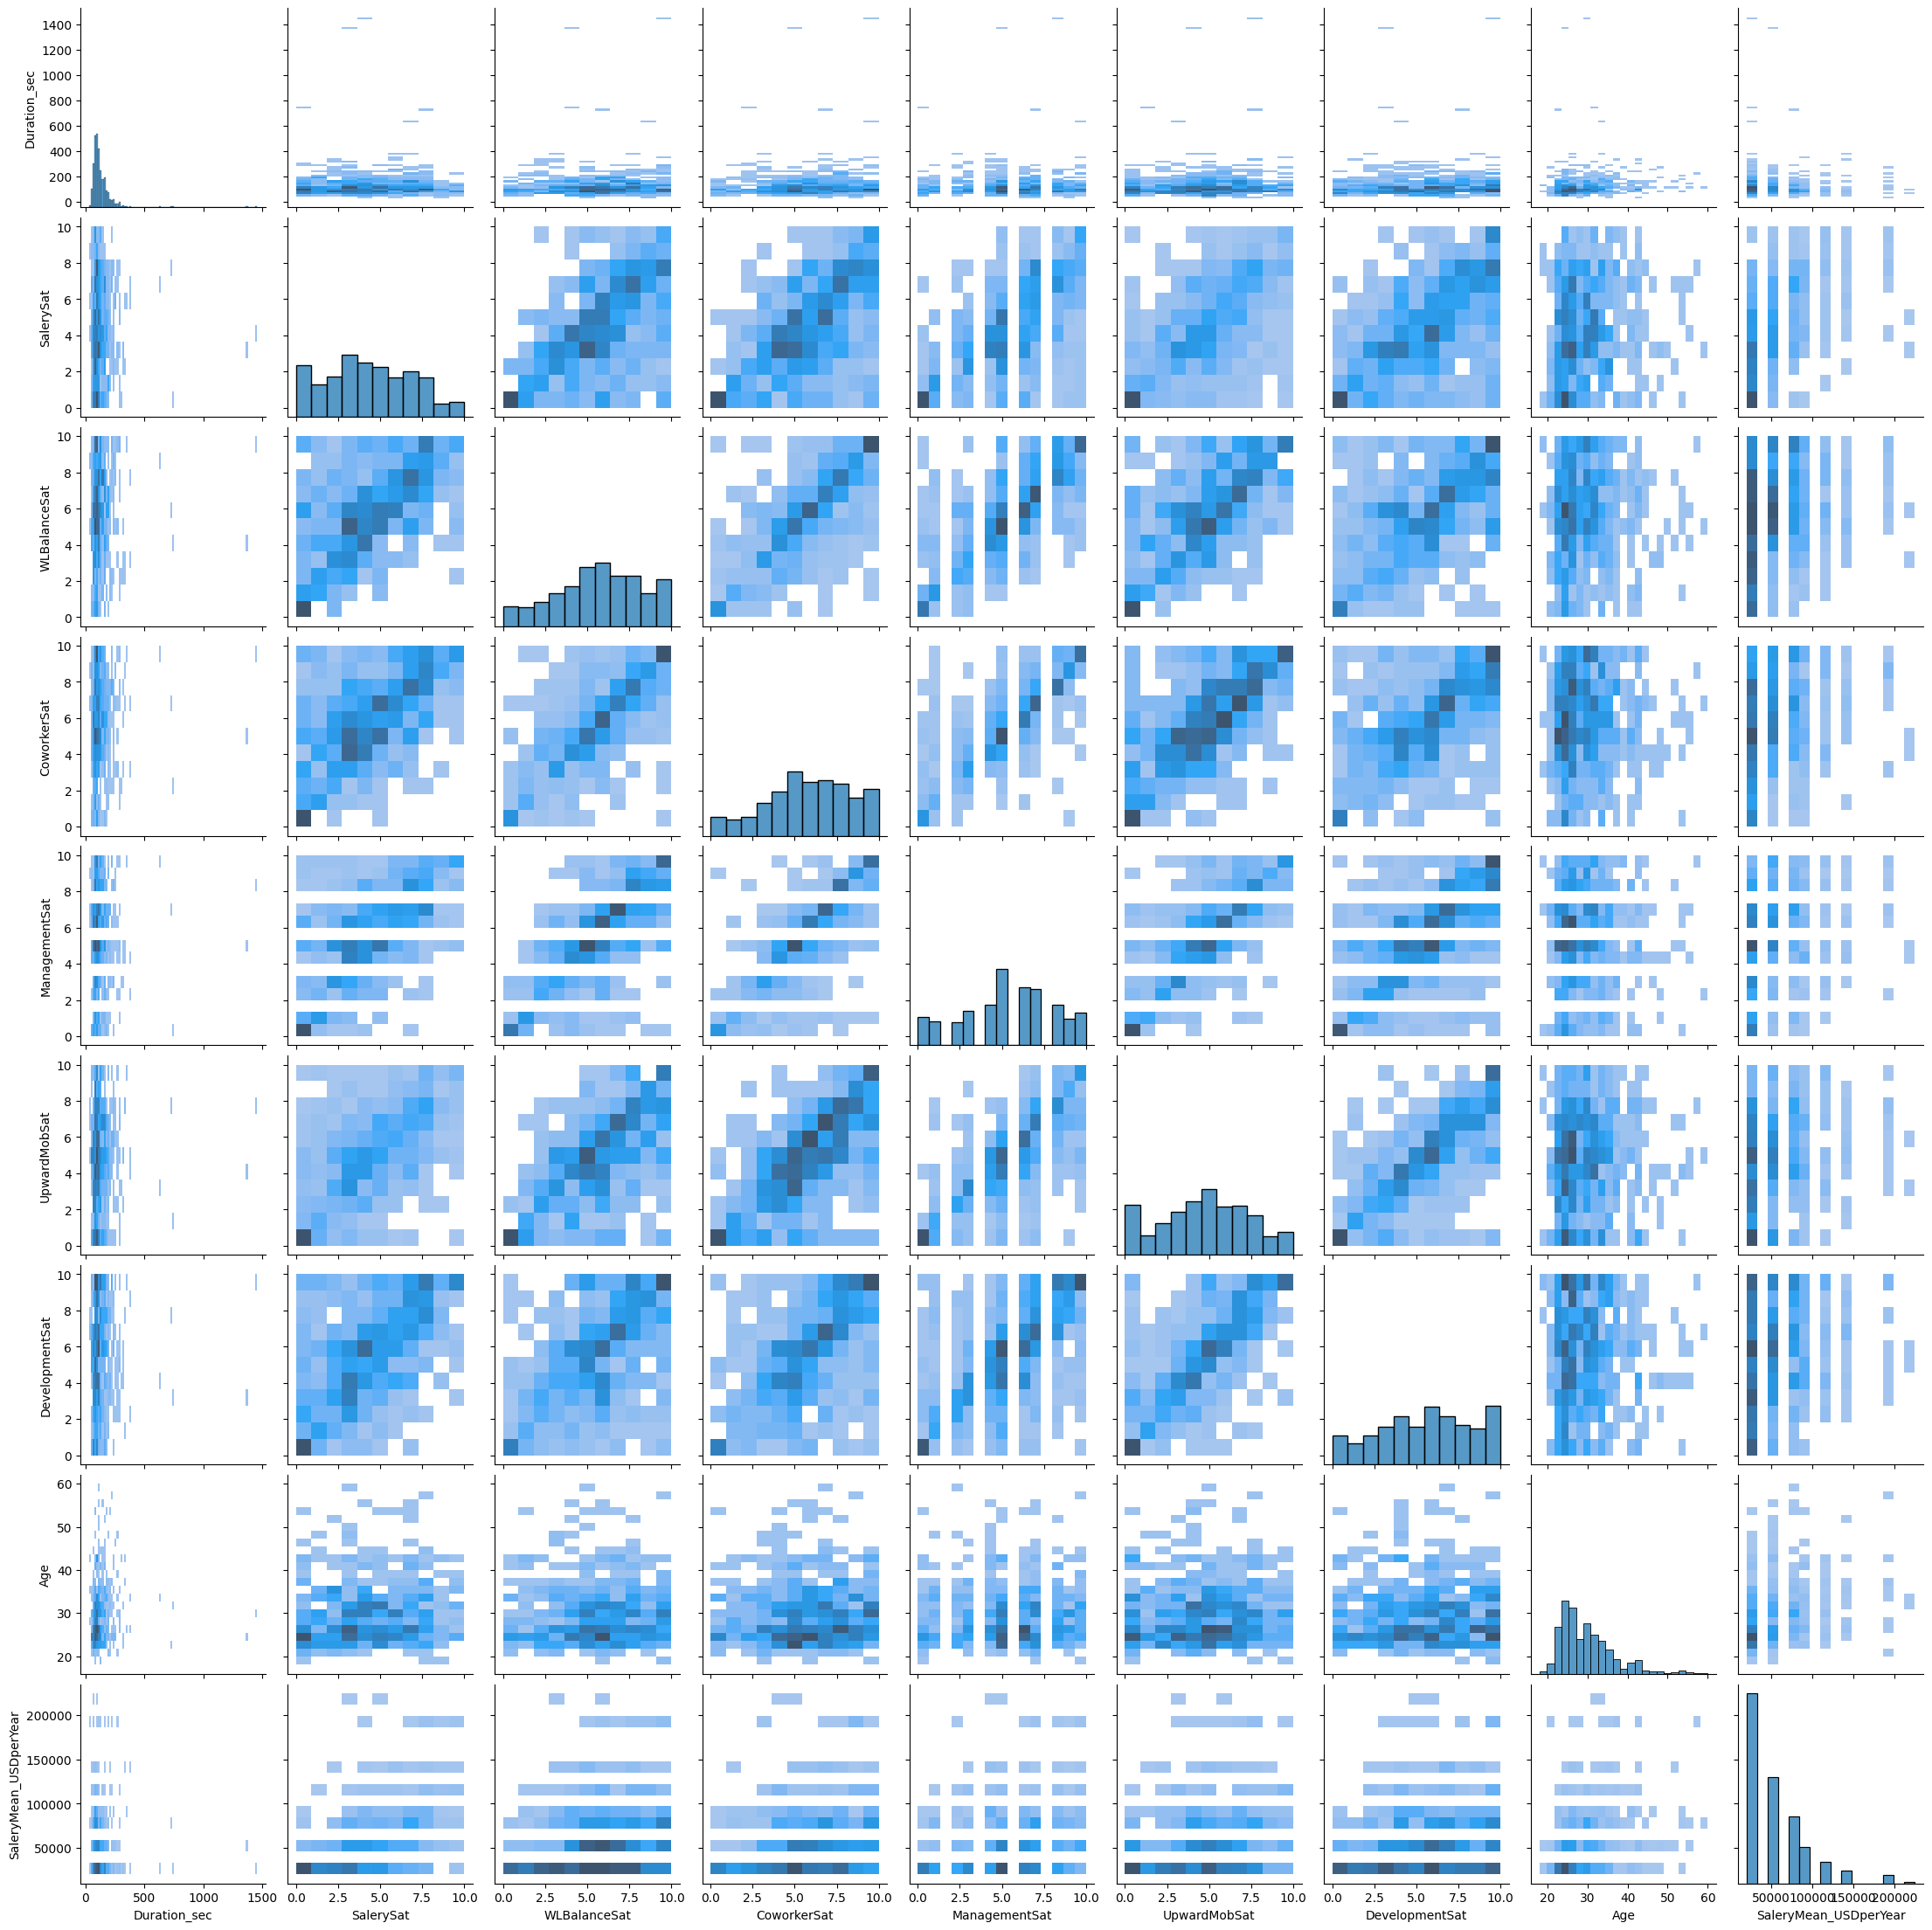

In [25]:
sns.pairplot(df[num_cols], kind="hist")

<Axes: >

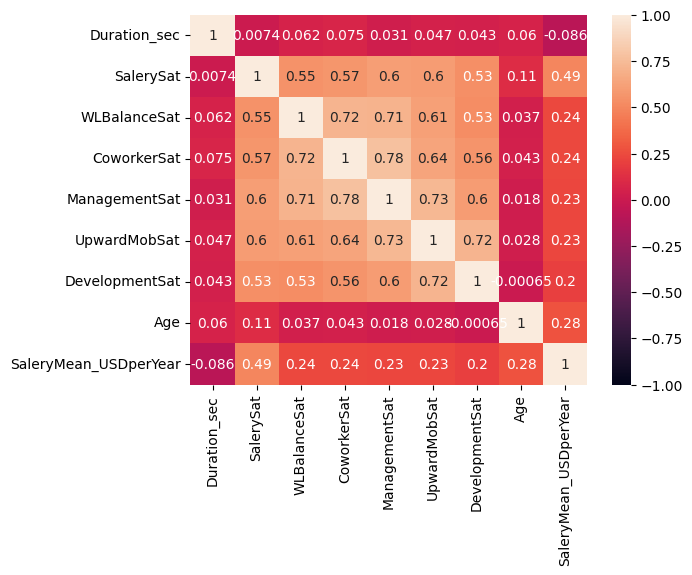

In [26]:
sns.heatmap(df[num_cols].corr(), annot = True, vmin = -1, vmax = 1)

In [27]:
cat_cols

['CurrentJob',
 'SaleryRange_USDperYear',
 'WorkField',
 'FavLanguage',
 'EntryDifficulty',
 'JobImportance',
 'Sex',
 'HomeContry',
 'Education',
 'Ethnicity',
 'WeekDay']

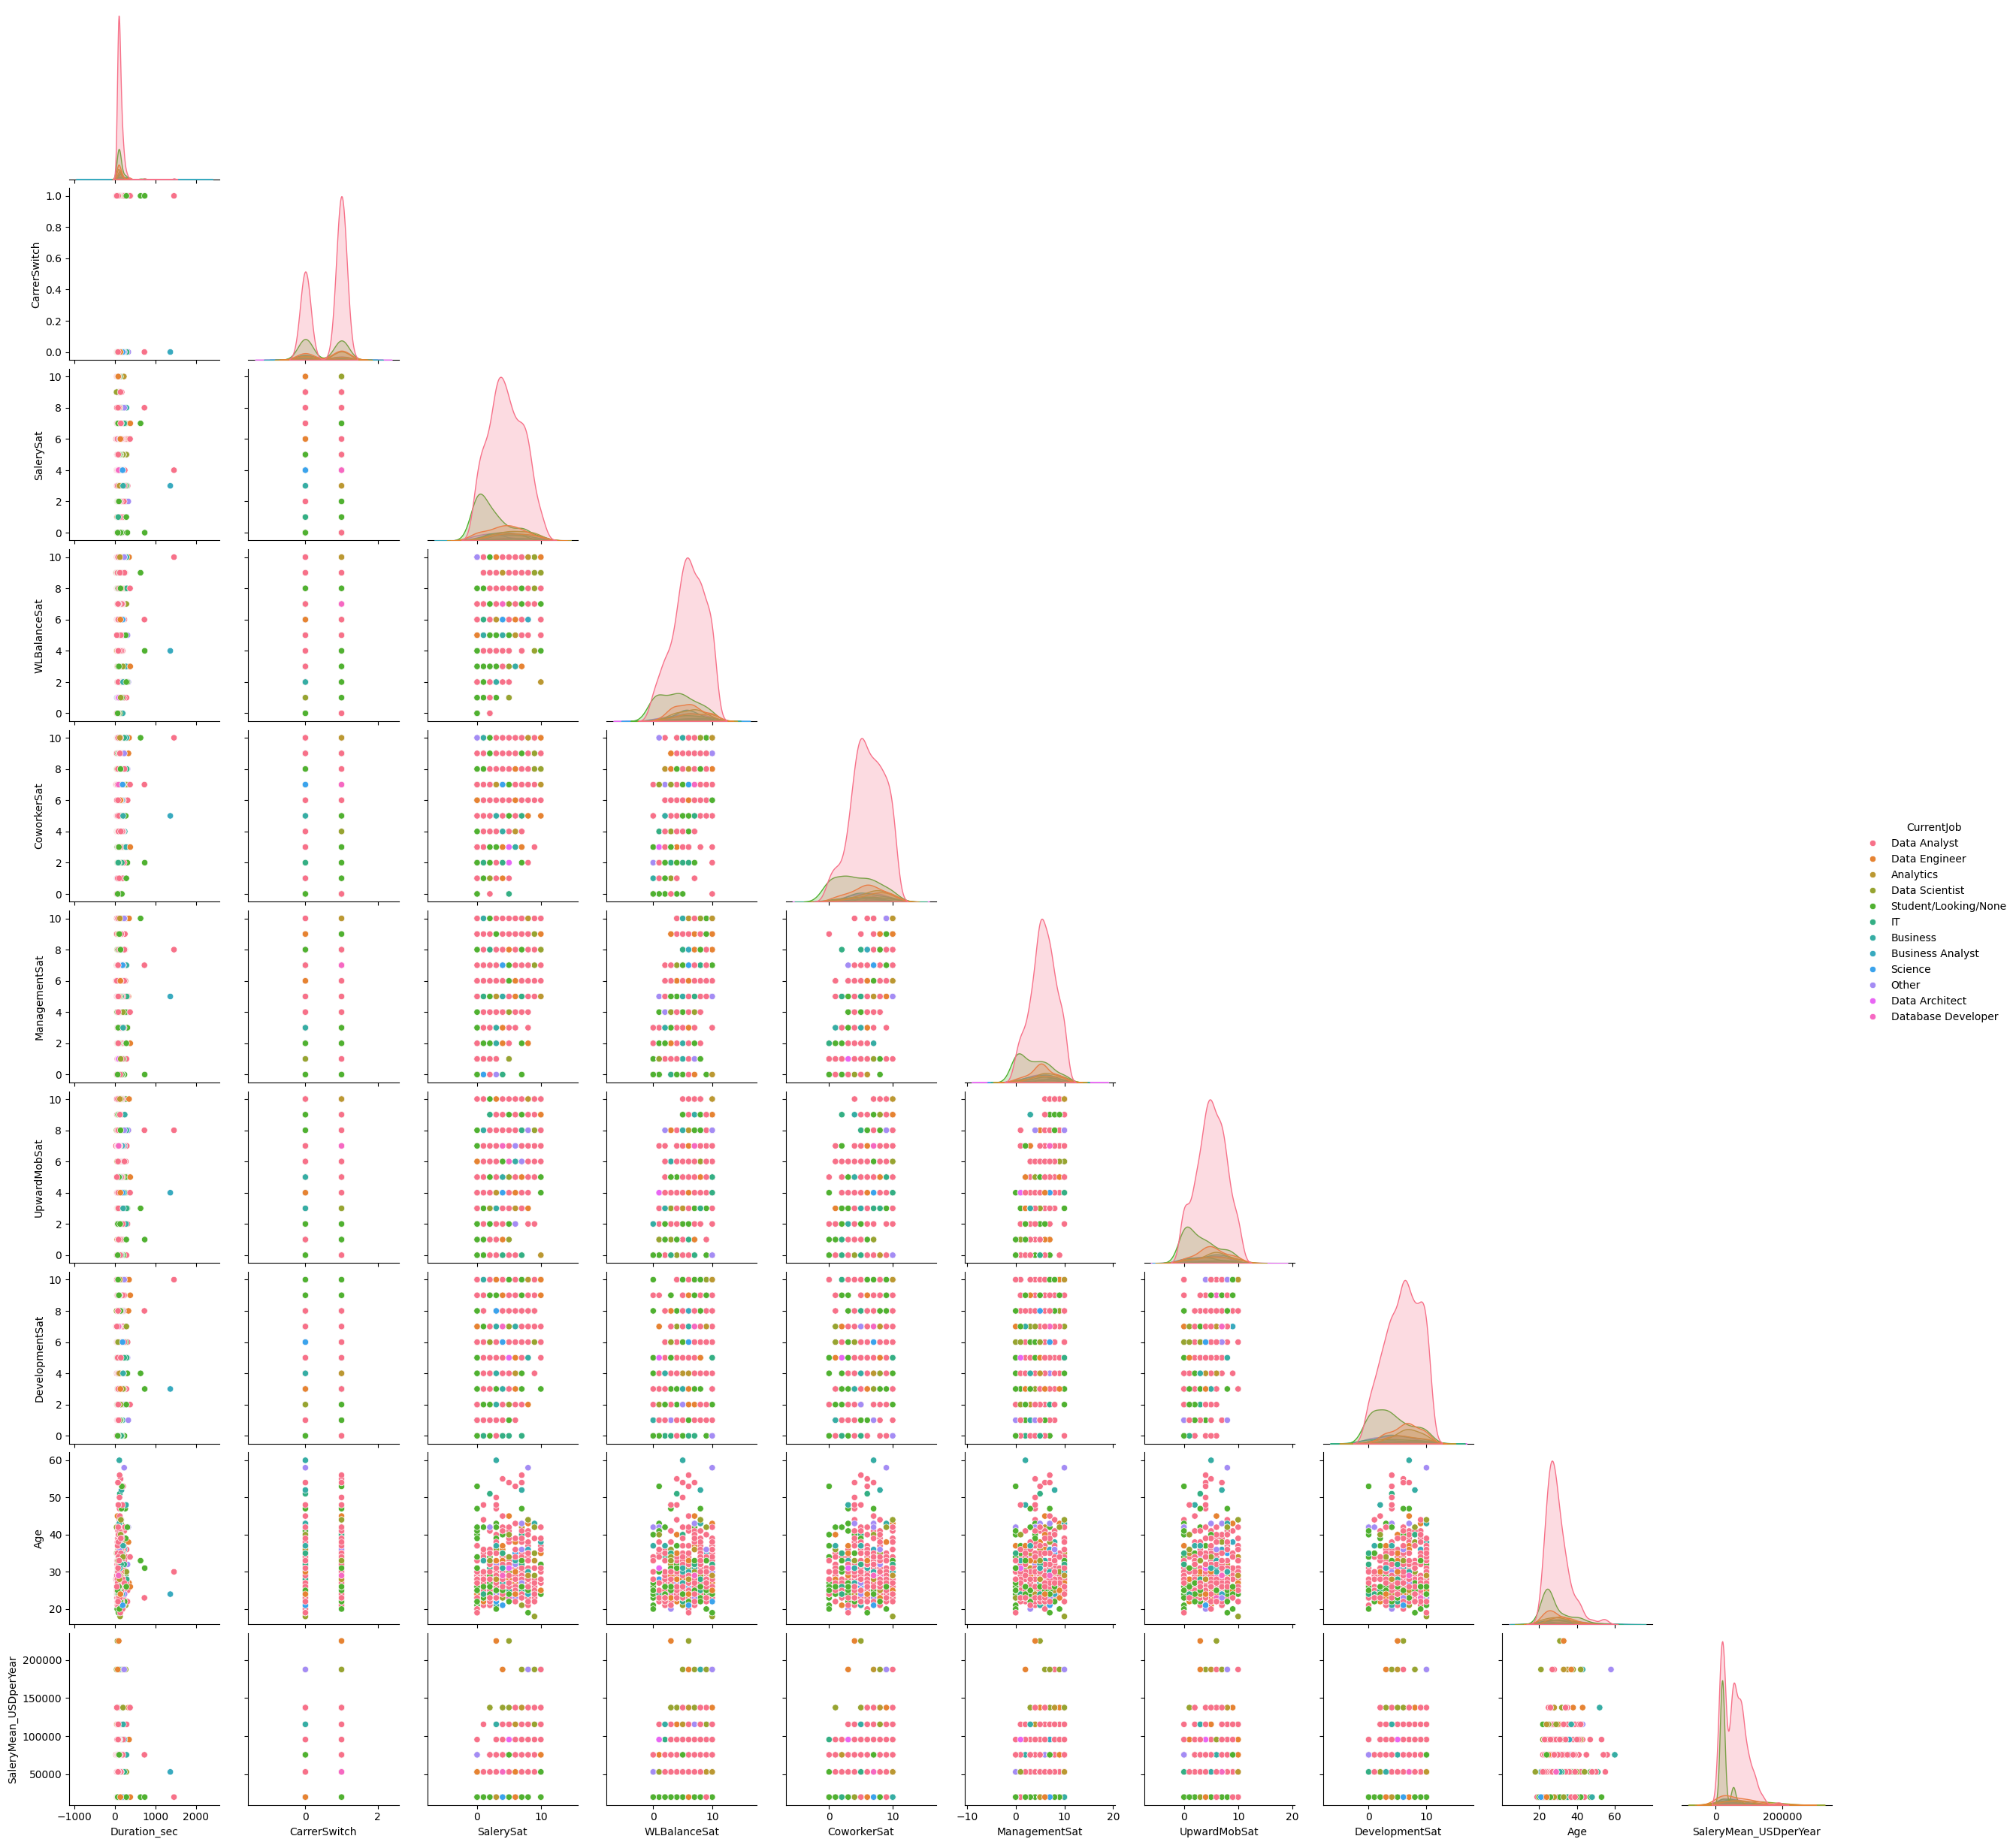

In [33]:
sns.pairplot(df, hue="CurrentJob", corner=True)

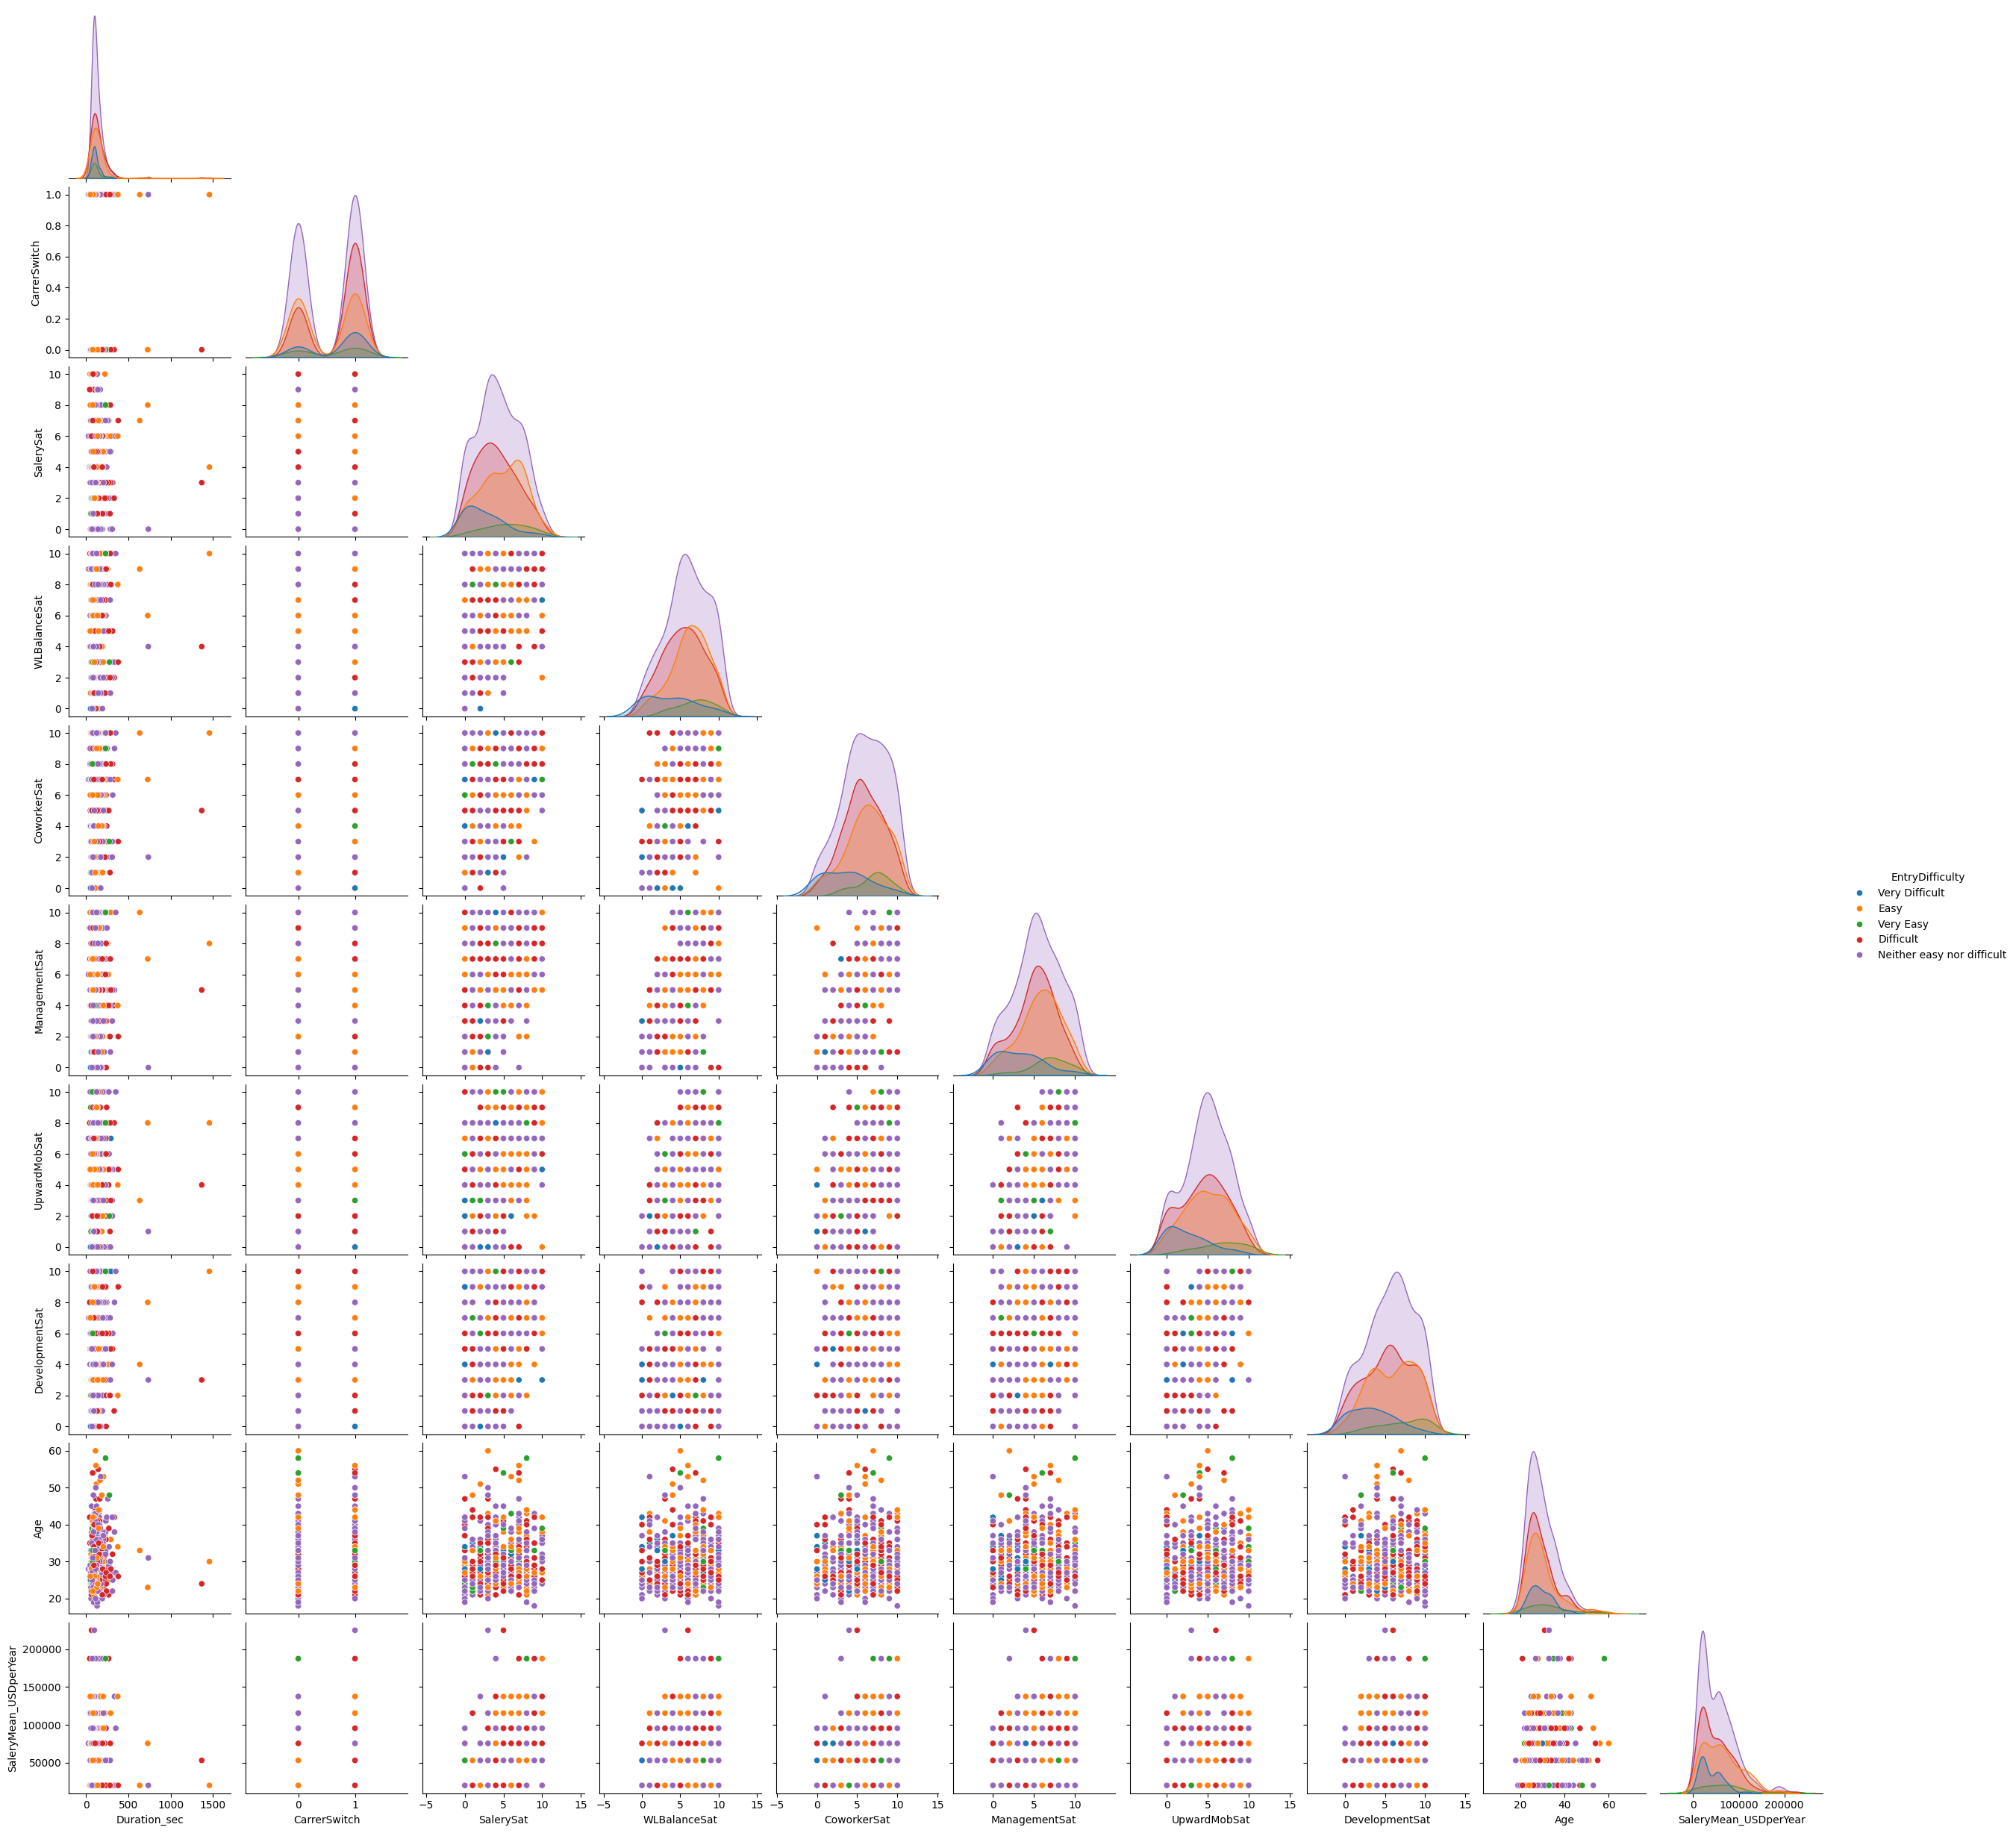

In [32]:
sns.pairplot(df, hue="EntryDifficulty", corner=True)

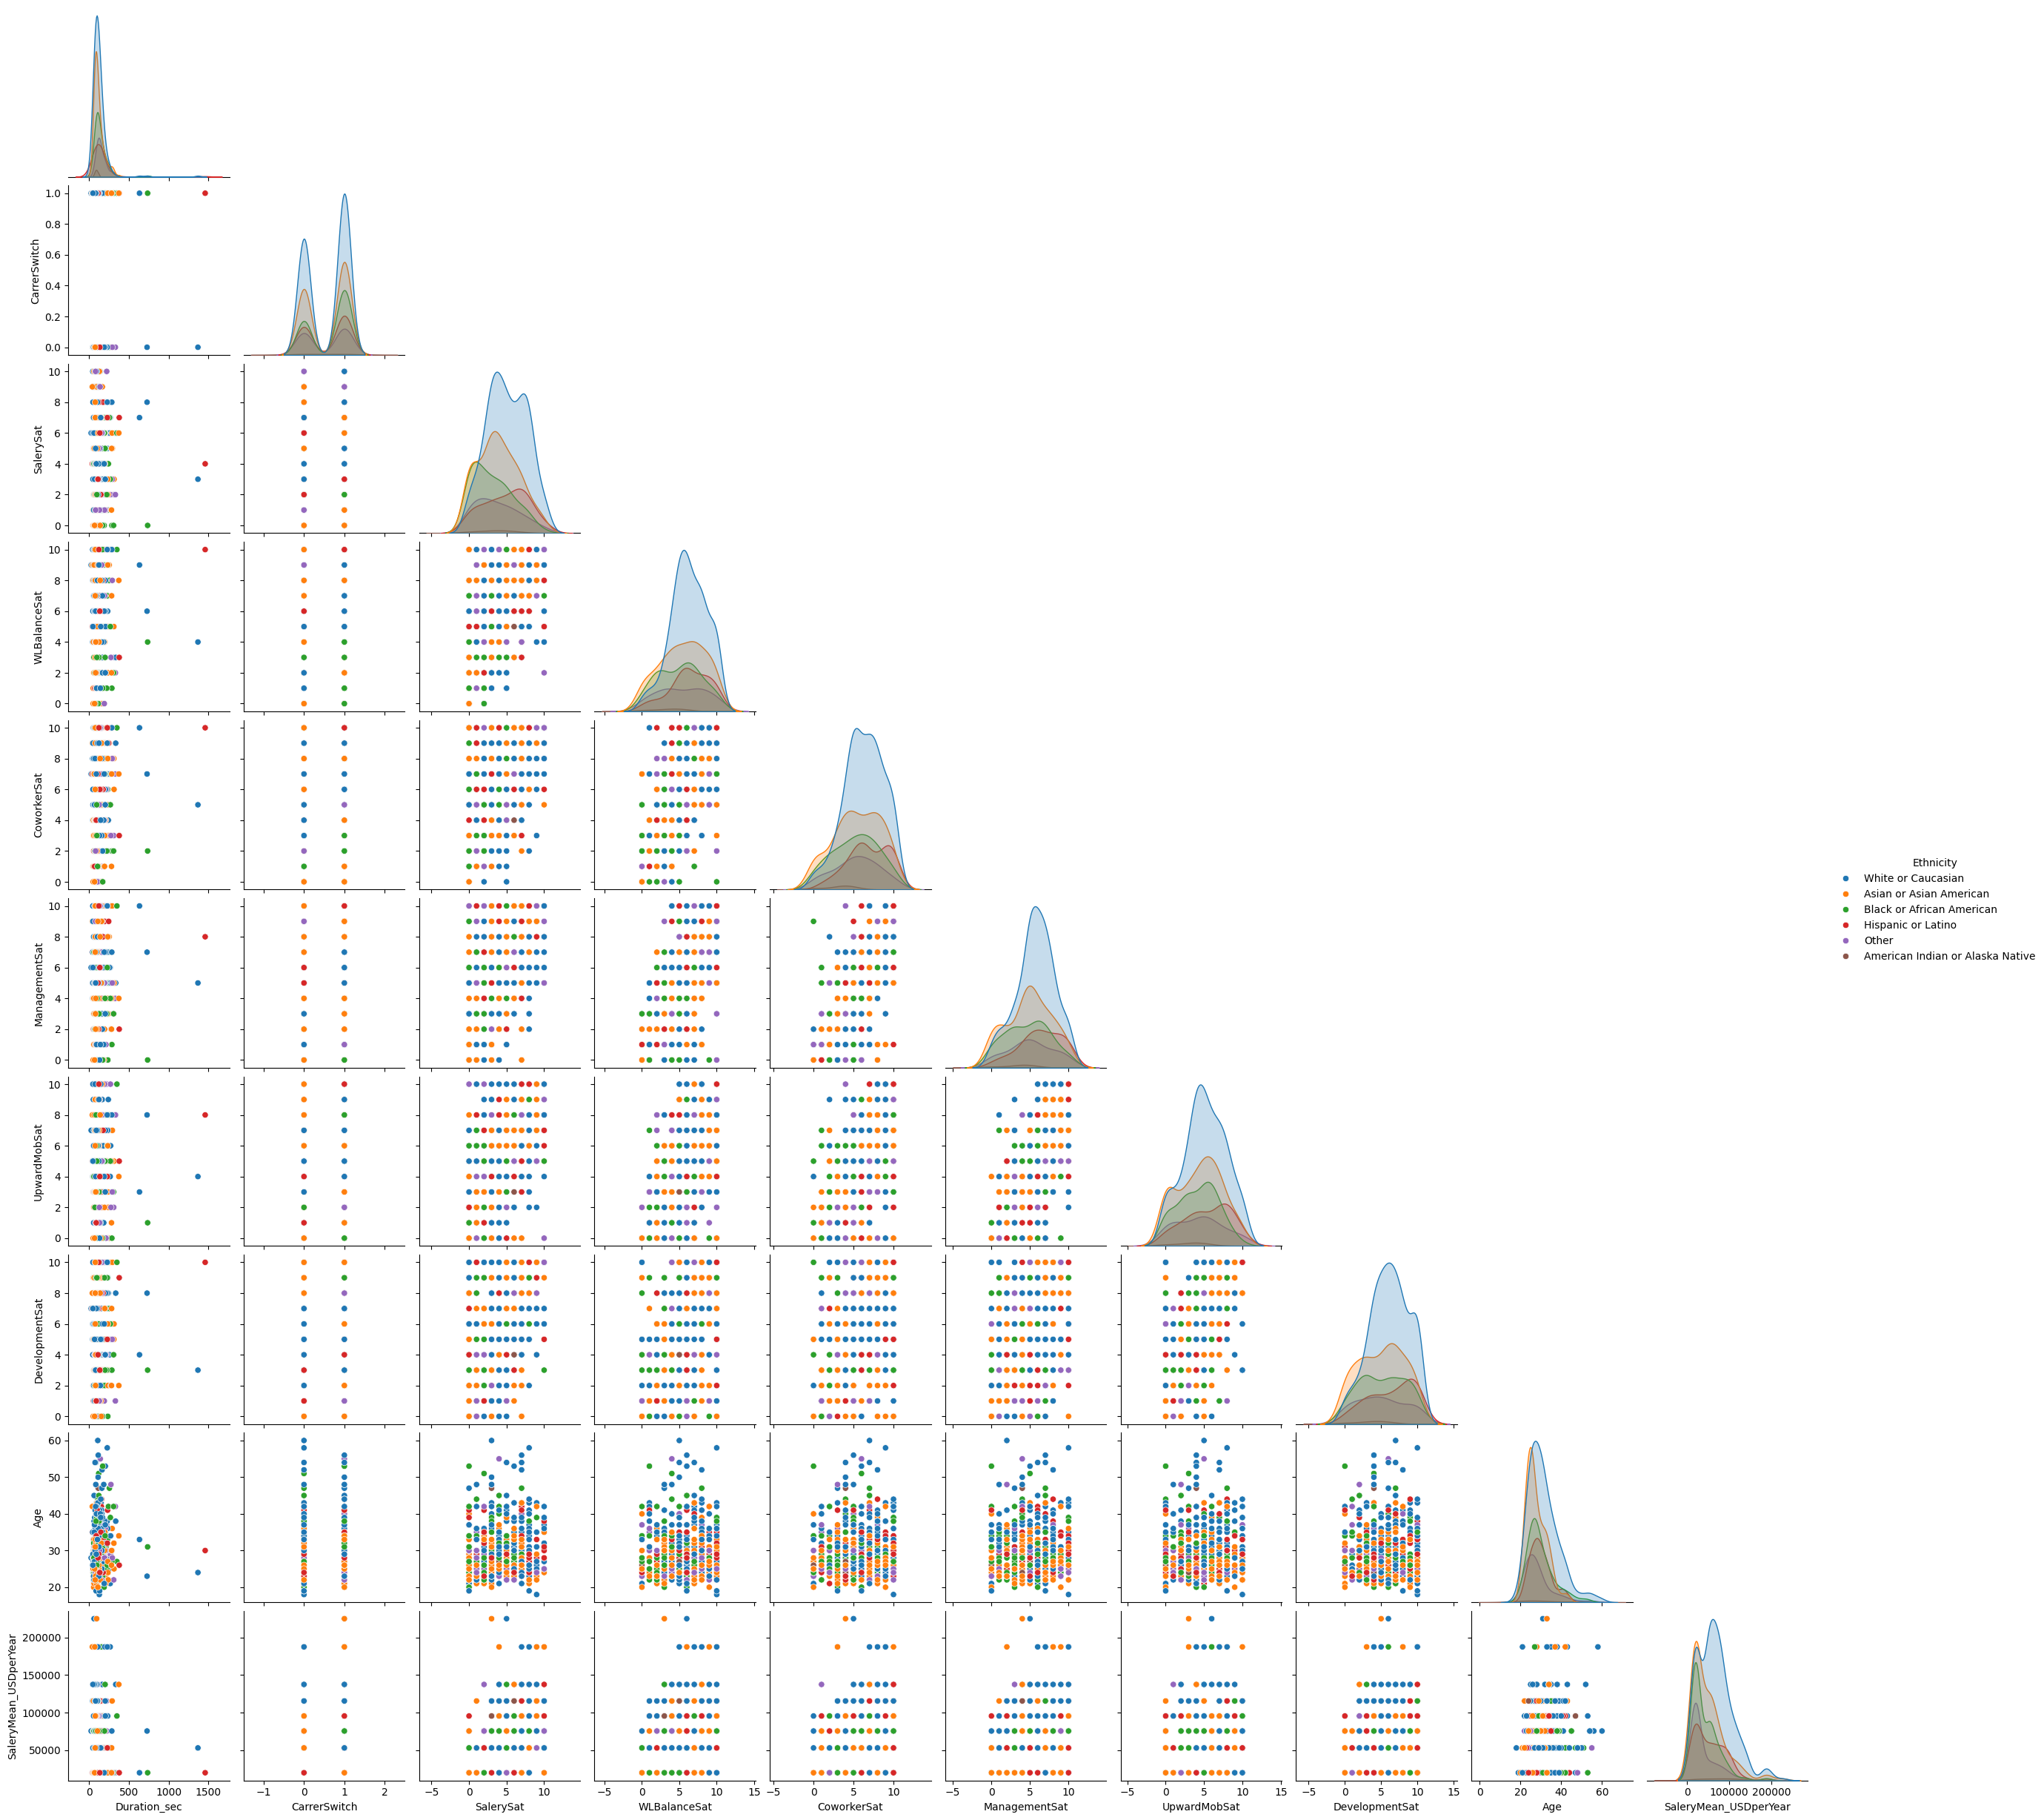

In [31]:
sns.pairplot(df, hue="Ethnicity", corner=True)

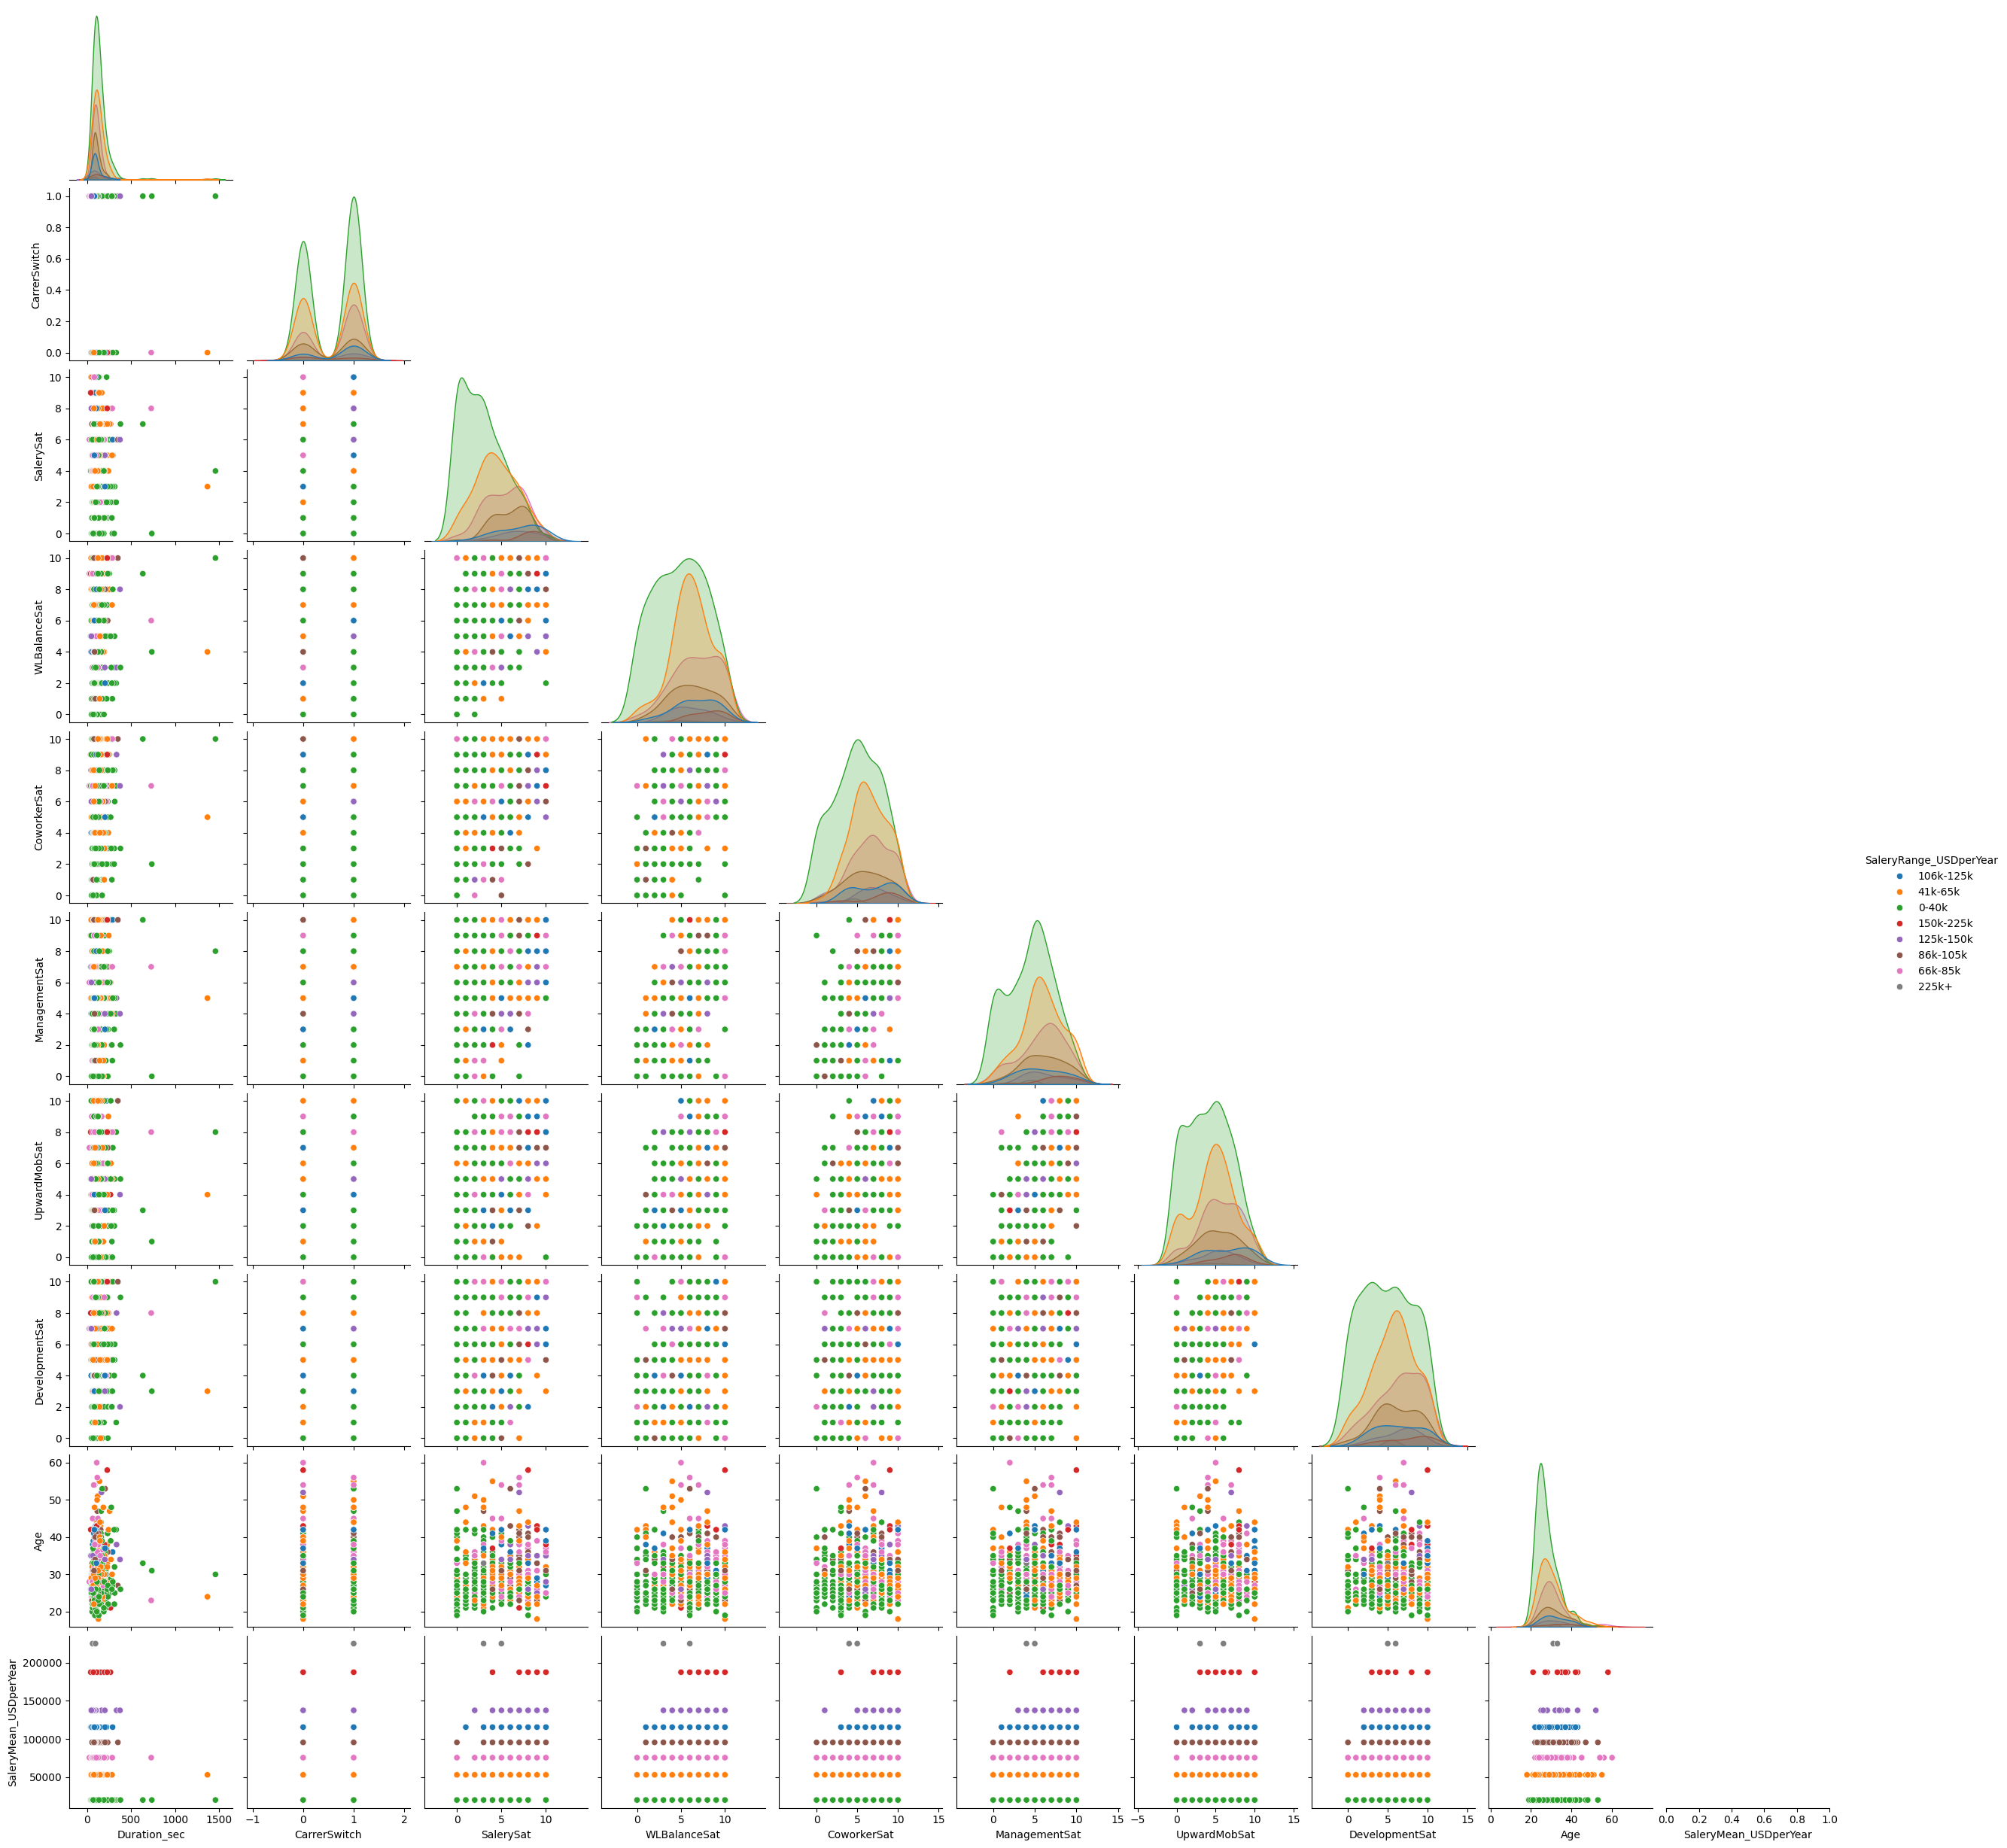

In [30]:
sns.pairplot(df, hue="SaleryRange_USDperYear", corner=True)

In [118]:
df['WeekDay'].value_counts()

WeekDay
Friday       339
Saturday     106
Sunday        59
Monday        42
Wednesday     27
Tuesday       22
Thursday      13
Name: count, dtype: int64

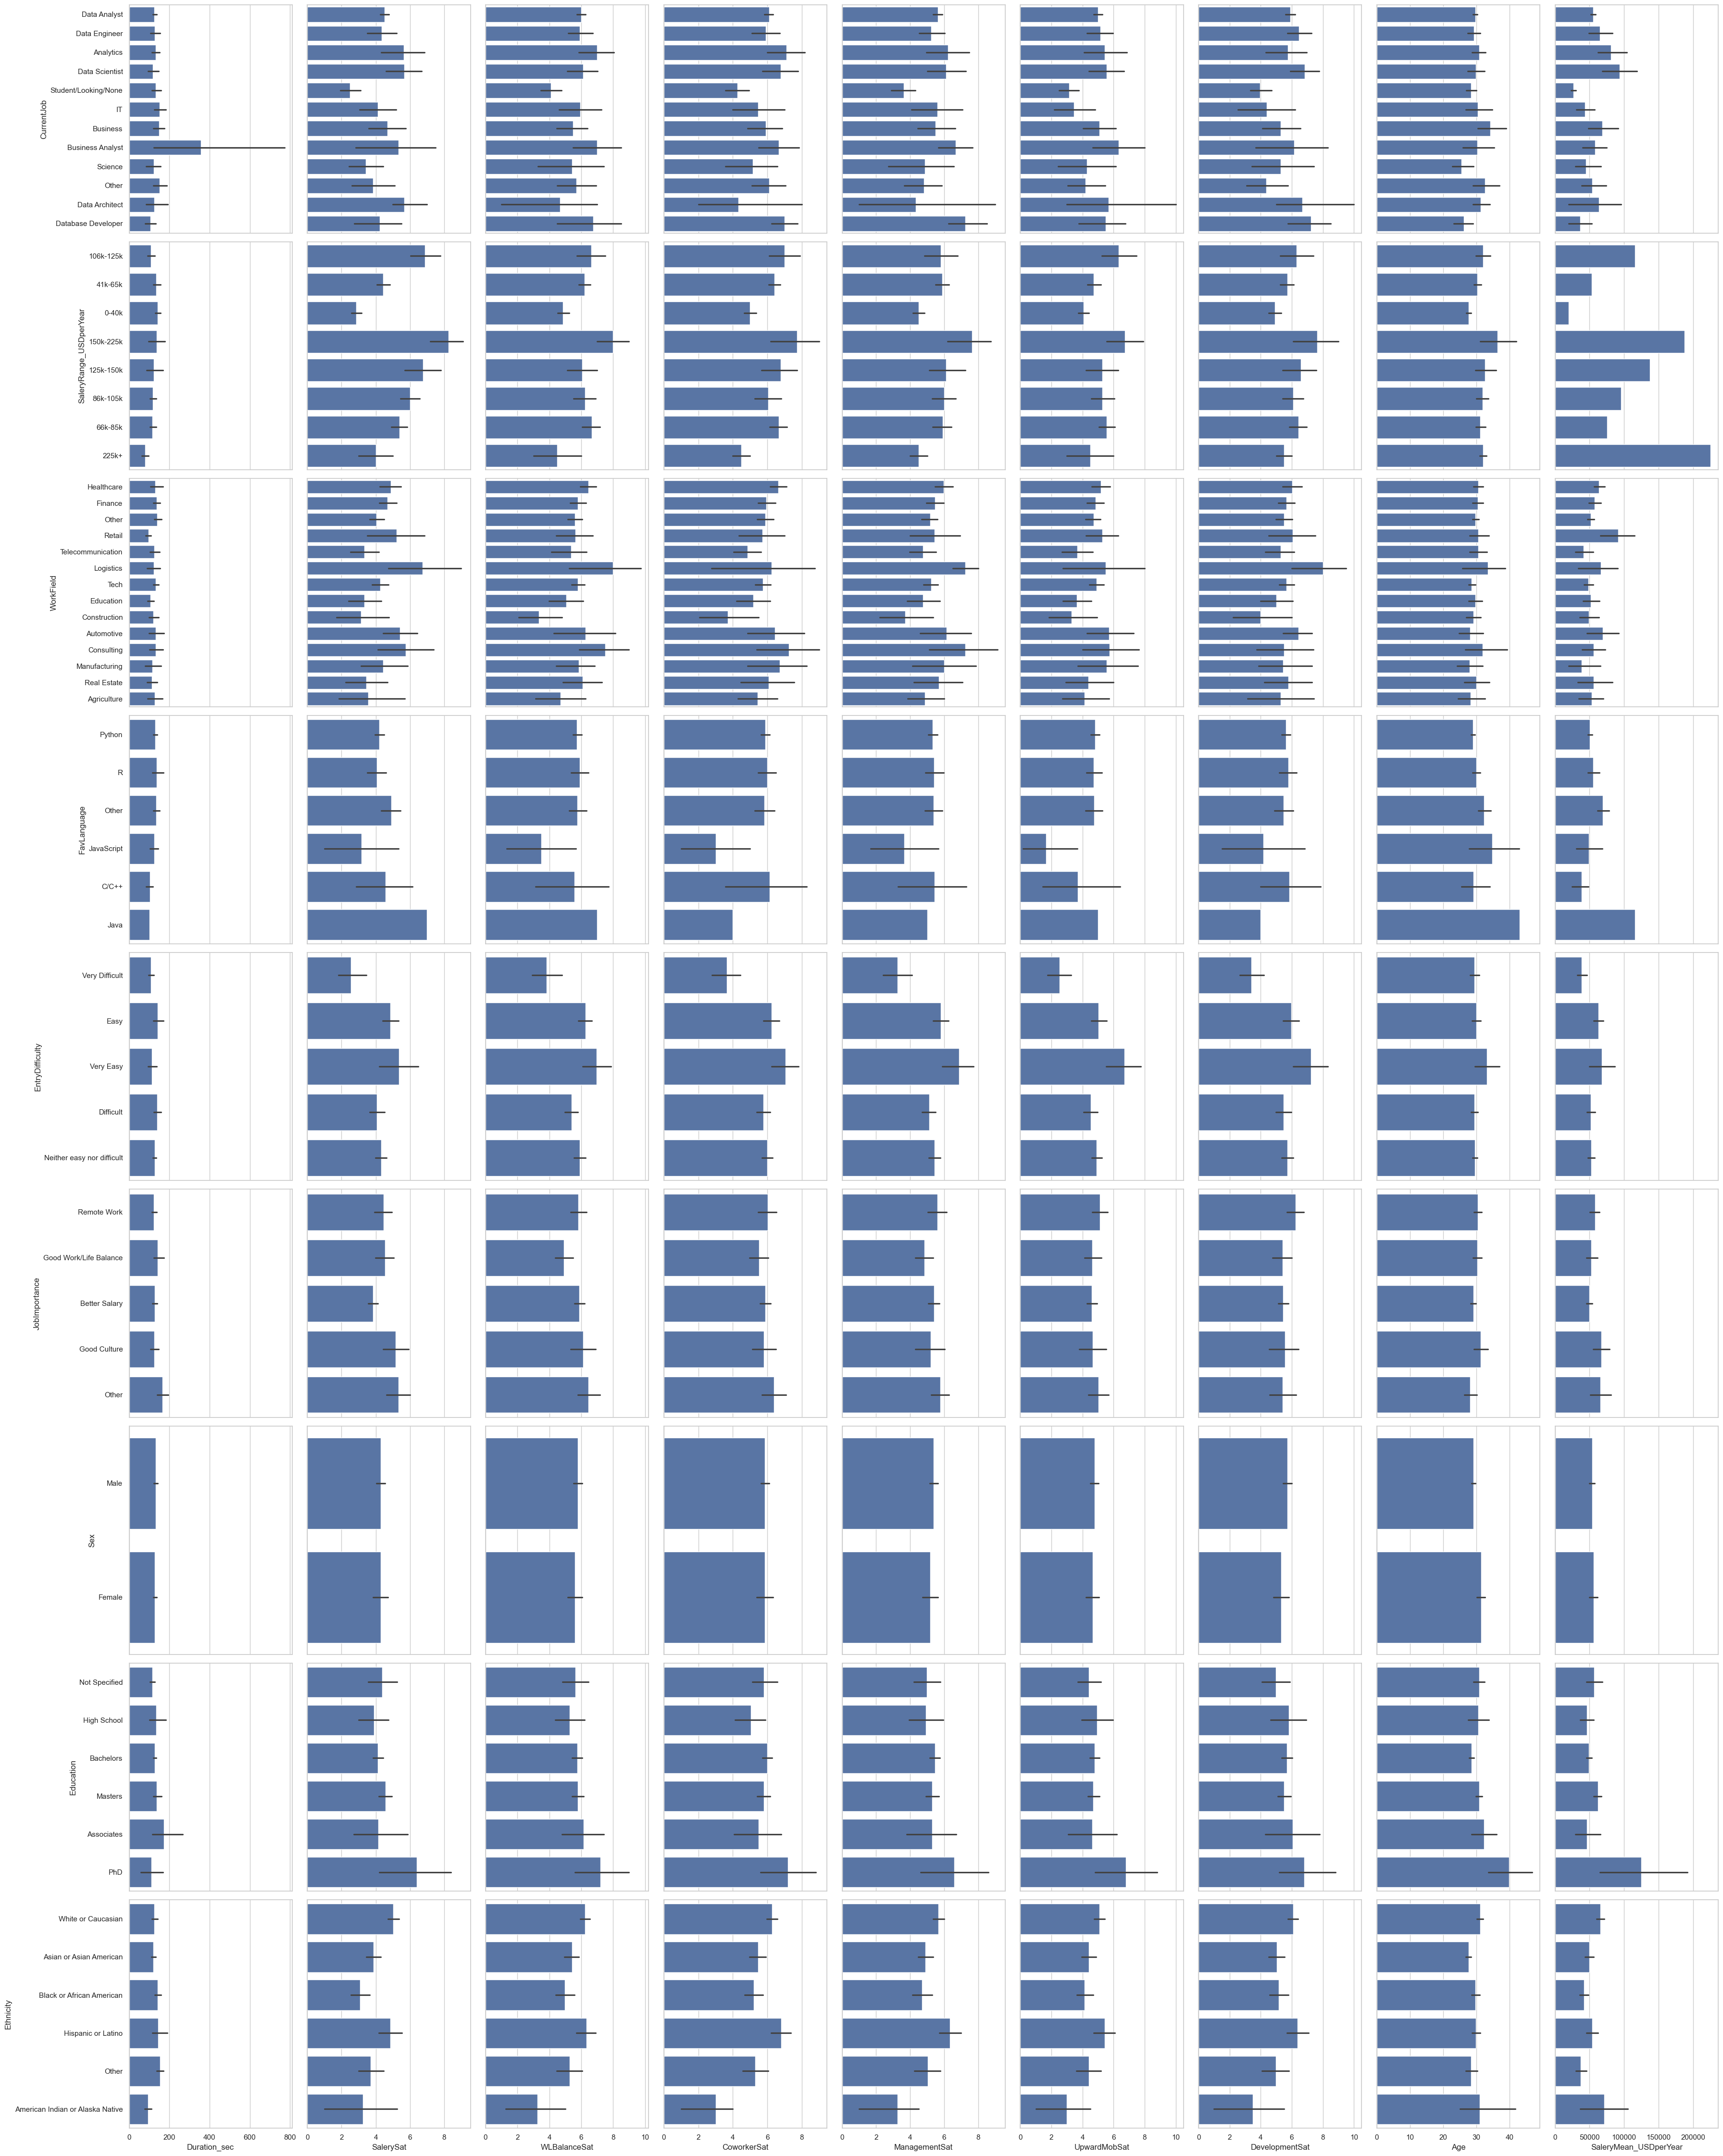

In [119]:
def plot_grid(df, x_cols, y_cols, kind:str='bar'):
    
    fig, axarr = plt.subplots(len(y_cols), len(x_cols), sharex='col', sharey='row', figsize = (4*len(x_cols), 5*len(y_cols)))
    for xi,x_col in enumerate(x_cols):
        for yi,y_col in enumerate(y_cols):
            g = sns.barplot(data=df, y=y_col, x=x_col, ax=axarr[yi,xi])
    fig.tight_layout()
    plt.show()


plot_grid(
    df, 
    y_cols=['CurrentJob','SaleryRange_USDperYear','WorkField','FavLanguage','EntryDifficulty','JobImportance','Sex','Education','Ethnicity'],
    x_cols=['Duration_sec','SalerySat','WLBalanceSat','CoworkerSat','ManagementSat','UpwardMobSat','DevelopmentSat','Age','SaleryMean_USDperYear']
)

In [143]:
123

123